# Data Preprocessing
### Brendon & Alec Barrios     |     08/08/2020
Using OSIC Pulmonary Fibrosis Progression dataset from Kaggle.com

<https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview>

Adapted from: <https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet>

In [1]:
import os
import pydicom
import pandas as pd

DATA_DIR = "train_dl/"
patients = os.listdir(DATA_DIR)

labels_df = pd.read_csv("train_dl.csv", index_col=0)

labels_df.head(20)

,Weeks,FVC,Percent,Age,Sex,SmokingStatus
Patient,,,,,,
ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker


In [21]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

IMAGE_PX_SIZE = 80  # recommended minimum: 70
NUM_SLICES = 30     # recommended minimum: 20
SAVE_FILE = "traindata-{}x{}x{}.npy".format(IMAGE_PX_SIZE, IMAGE_PX_SIZE, NUM_SLICES)

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l)/len(l)

def normalize(a):
    norm = np.linalg.norm(a)
    if norm == 0:
        return a
    return a / norm

def process_data(patient, labels_df, img_px_size=70, num_slices=20, visualize=False):
    
    path = os.path.join(DATA_DIR, patient)
    slices = [pydicom.read_file(os.path.join(path, file)) for file in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) # sorts dicom files by Image Position
#     print(slices[0])
    
    new_slices = []
    slices = [cv2.resize(normalize(each_slice.pixel_array), (img_px_size, img_px_size)) for each_slice in slices]
           
    chunk_step = math.ceil(len(slices) / num_slices) # (num_slices^2 + 1)/num_slices
    
    # Chunks and averages images for patients with >40 images
    for slice_chunk in chunks(slices, chunk_step):
        avg_slice = list(map(mean, zip(*slice_chunk)))
        new_slices.append(avg_slice)
    
    print(len(new_slices))    
    
    # Handle data with less than num_slices images
    diff = num_slices - len(new_slices)
    if diff:
        for n in range(diff):
            mid = int(len(new_slices) / 2)
            # possibly mirror the duplicate images(?)
            new_slices.append(new_slices[mid])
        
    # Handle data with more than num_slices images
    while len(new_slices) > num_slices:
        new_img = list(map(mean, zip(*[new_slices[-1], new_slices[-2]])))
        del new_slices[num_slices]
        new_slices[num_slices - 1] = new_img
        
    print(len(new_slices))
    
    if visualize:
        cols = int(num_slices / 5)
        fig = plt.figure(figsize=(16,12)) # double the default figsize
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(5, cols, num+1)
            y.imshow(each_slice, cmap = "gray")
        plt.show
        
    '''
    Obtain slope of FVC Score as label
    Possibly check R^2 values as a counterpart to confidence score
    Check if non-linear functions describe FVC trends better than linear functions
    If so, brainstorm a numeric readout (to replace slope) from the non-linear f(x) that works best
    '''
    FVC = np.array(labels_df.at[patient, "FVC"])
    wk = np.array(labels_df.at[patient, "Weeks"])
    m, b = np.polyfit(wk, FVC, 1)
        
    return np.array(new_slices), -m, b

30
30
29
30
27
30
GDCM required!
25
30
Save successful!


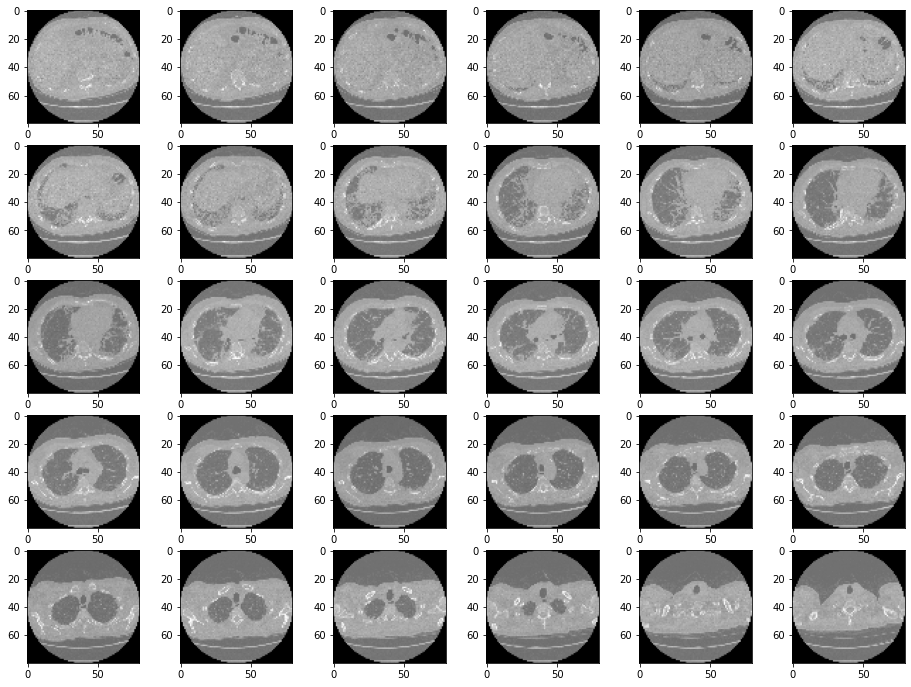

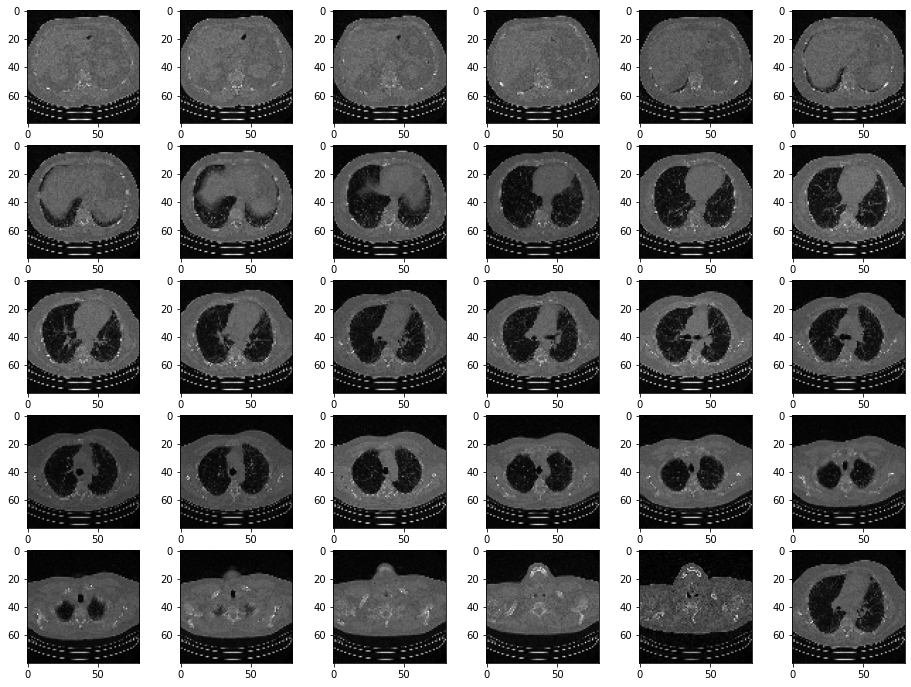

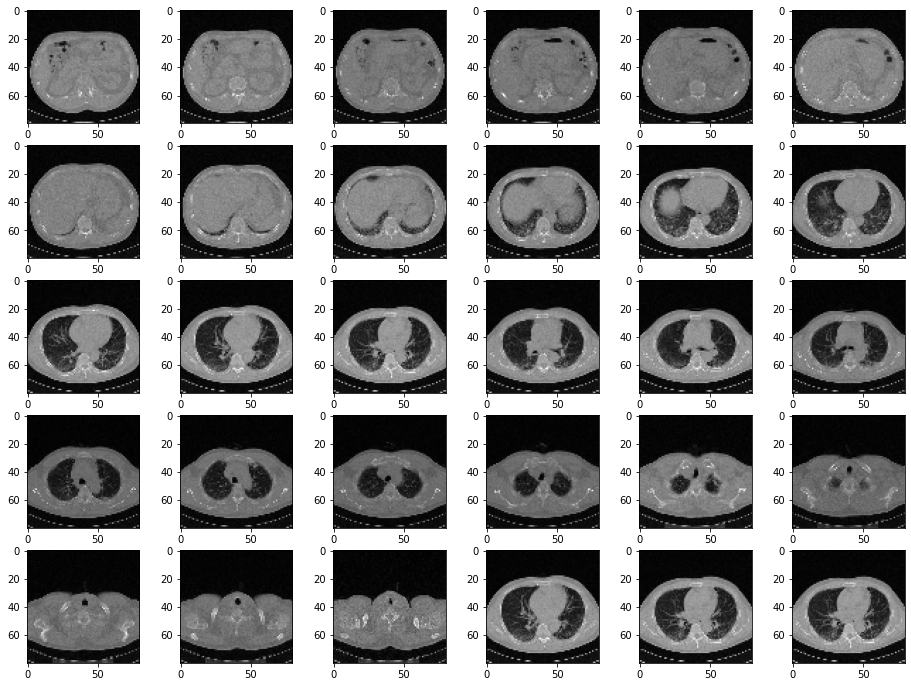

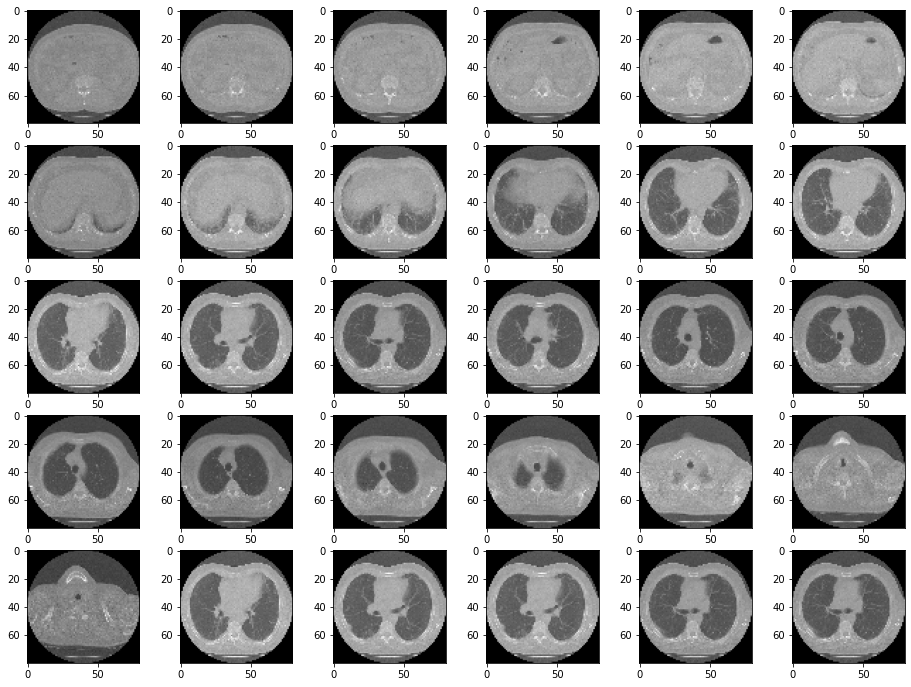

In [22]:
"""
Try Preprocessing Data 
If memory fails: try to process "online", meaning call process_data() while network is training to feed data into network
"""
much_data = []

for num, patient in enumerate(patients[:5]):
    if num%100 == 0 and num != 0:
        print(num)
    
    """
    This is a work-around for files that require GDCM to read. Try using get_pixeldata() method to work.
    """      
    try:
        img_data, label, intercept = process_data(patient, 
                                                  labels_df, 
                                                  img_px_size=IMAGE_PX_SIZE, 
                                                  num_slices=NUM_SLICES, 
                                                  visualize=True)
        
        much_data.append([img_data, label, intercept])
        
    except KeyError:
        print("Unlabeled data!") # error that Sentdex handled
        
    except RuntimeError:
        print("GDCM required!") # error that we are encountering
        
np.save(SAVE_FILE, much_data, allow_pickle=True)
print("Save successful!")

-8.543078528986696
8.543078528986696


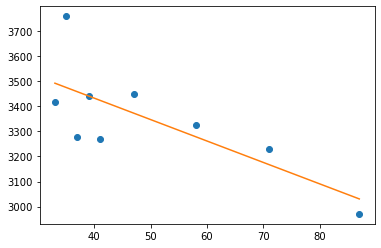

In [23]:
FVC = np.array(labels_df.at[patient, "FVC"])
wk = np.array(labels_df.at[patient, "Weeks"])
m, b = np.polyfit(wk, FVC, 1)
plt.plot(wk, FVC, 'o')
plt.plot(wk, m*wk + b)
print(m)
print(-m)

In [24]:
"""
Proof of Save/Load states:
"""
images = np.load(SAVE_FILE, allow_pickle=True)

In [25]:
print("Raw Data: ", images[3])

Raw Data:  [array([[[-0.00387581, -0.00387581, -0.00387581, ..., -0.00387581,
         -0.00387581, -0.00387581],
        [-0.00387581, -0.00387581, -0.00387581, ..., -0.00387581,
         -0.00387581, -0.00387581],
        [-0.00387581, -0.00387581, -0.00387581, ..., -0.00387581,
         -0.00387581, -0.00387581],
        ...,
        [-0.00387581, -0.00387581, -0.00387581, ..., -0.00387581,
         -0.00387581, -0.00387581],
        [-0.00387581, -0.00387581, -0.00387581, ..., -0.00387581,
         -0.00387581, -0.00387581],
        [-0.00387581, -0.00387581, -0.00387581, ..., -0.00387581,
         -0.00387581, -0.00387581]],

       [[-0.00389789, -0.00389789, -0.00389789, ..., -0.00389789,
         -0.00389789, -0.00389789],
        [-0.00389789, -0.00389789, -0.00389789, ..., -0.00389789,
         -0.00389789, -0.00389789],
        [-0.00389789, -0.00389789, -0.00389789, ..., -0.00389789,
         -0.00389789, -0.00389789],
        ...,
        [-0.00389789, -0.00389789, -0.0038

Normalized Image Data:
 [[-0.00389789 -0.00389789 -0.00389789 ... -0.00389789 -0.00389789
  -0.00389789]
 [-0.00389789 -0.00389789 -0.00389789 ... -0.00389789 -0.00389789
  -0.00389789]
 [-0.00389789 -0.00389789 -0.00389789 ... -0.00389789 -0.00389789
  -0.00389789]
 ...
 [-0.00389789 -0.00389789 -0.00389789 ... -0.00389789 -0.00389789
  -0.00389789]
 [-0.00389789 -0.00389789 -0.00389789 ... -0.00389789 -0.00389789
  -0.00389789]
 [-0.00389789 -0.00389789 -0.00389789 ... -0.00389789 -0.00389789
  -0.00389789]]


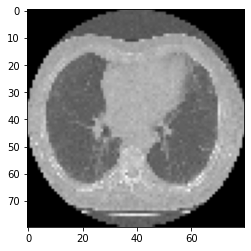

In [26]:
print("Normalized Image Data:\n", images[3,0][1])
plt.figure()
plt.imshow(images[3,0][25], cmap='gray')
plt.show()

### Proof of concept: Loading in training/validation data

In [8]:
x_train = []
y_train = []
b = []
for n in range(len(images)):
    x_train.append(images[n, 0])
    y_train.append(images[n, 1])
    b.append(images[n, 2])
X = np.array(x_train)
Y = np.array(y_train)
print(X.shape)
print(Y.shape)
50**3

(4, 50, 60, 60)
(4,)


125000